# !unzip data_input4.zip

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras import regularizers
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.utils import plot_model
import graphviz, pydot, pydotplus
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [37]:
root_folder = "data_input4/01_healthy"
healthy = []
for root, dirs, files in os.walk(root_folder):  
    for filename in files:
        healthy.append(filename)

In [38]:
measurements = []
classifications = []
count_healhy = 0
for sample in healthy:
    df = pd.read_csv(os.path.join(root_folder,sample), sep='\t',skiprows=[0],
        header=None, names=[ 'Wave', 'Intensity'])
    measurements.append(df[['Intensity']].to_numpy())
    classifications.append([1,0])
    count_healhy += 1

print(f'Здоровые ткани: {count_healhy}')

Здоровые ткани: 432


In [39]:
sick_path = 'image_tumor_patient20022019_633nm_obj20_power100_1sec_сenter2900.txt'
count_sick = 0
df = pd.read_csv(sick_path, sep='\t',skiprows=[0],
    header=None, names=['X', 'Y', 'Wave', 'Intensity'])
for i in range(456):
    measurements.append(df[['Intensity']][i*len(df['Wave'].unique()):(i+1)*len(df['Wave'].unique())].to_numpy())
    classifications.append([0,1])
    count_sick += 1

print(f'Больные ткани: {count_sick}')
print(f'Всего образцов: {count_healhy + count_sick}')

Больные ткани: 456
Всего образцов: 888


In [40]:
X = np.asarray(measurements)
y = np.asarray(classifications)

In [41]:
X.shape

(888, 1015, 1)

In [42]:
X = X.reshape(888, 1015)
X.shape

(888, 1015)

In [43]:
y.shape

(888, 2)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f'Total amount of train measurements: {X_train.shape}')
print(f'Total amount of train labels: {y_train.shape}')
print(f'Total amount of test measurements: {X_test.shape}')
print(f'Total amount of test labels: {y_test.shape}')
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

Total amount of train measurements: (666, 1015)
Total amount of train labels: (666, 2)
Total amount of test measurements: (222, 1015)
Total amount of test labels: (222, 2)


Precision - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными

Recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

F1 - среднее гармоническое precision и recall

In [45]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [48]:
# Model 1
model = Sequential()
model.add(Conv1D(128, 4, activation='relu', input_shape=(1015,1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 32 neurons
model.add(Conv1D(128, 4, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 32 neurons
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Conv1D(256, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 64 neurons
model.add(Conv1D(256, 2, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 64 neurons
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(128, activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(64, activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])
model_hist = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 1012, 128)         640       
                                                                 
 conv1d_41 (Conv1D)          (None, 1009, 128)         65664     
                                                                 
 batch_normalization_50 (Bat  (None, 1009, 128)        512       
 chNormalization)                                                
                                                                 
 activation_50 (Activation)  (None, 1009, 128)         0         
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 504, 128)         0         
 g1D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 504, 128)        

In [49]:
acc = model.evaluate(X_test, y_test)
print("Loss:", acc[0], " Accuracy:", acc[1], " F1 :", acc[2])
pred = model.predict(X_test)
print(np.round(pred,2)[0], np.round(pred,2)[1])
#model2.save("3.h5")

7/7 [==============================] - 0s 13ms/step - loss: 0.3880 - accuracy: 0.8423 - f1: 0.8426
Loss: 0.38798433542251587  Accuracy: 0.8423423171043396  F1 : 0.8425594568252563
7/7 [==============================] - 0s 10ms/step
[0.98 0.02] [0.77 0.23]


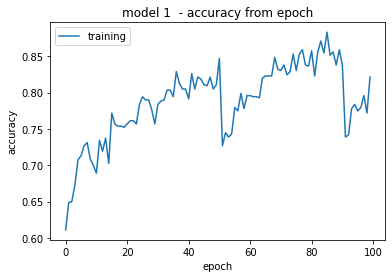

In [50]:
loss, accuracy, f1  = model.evaluate(X_test, y_test, verbose=False)

plt.plot(model_hist.history['accuracy'])
plt.title('model 1  - accuracy from epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [17]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
model_catboost = CatBoostClassifier(verbose=False)
model_catboost.fit(X_train, y_train_labels)
print(f'CatBoost F1 Score {f1_score(y_test_labels, model_catboost.predict(X_test))}')

from sklearn.metrics import accuracy_score
print(f'CatBoost Accuracy {accuracy_score(y_test_labels, model_catboost.predict(X_test))}')

CatBoost F1 Score 0.9315068493150686
CatBoost Accuracy 0.9253731343283582


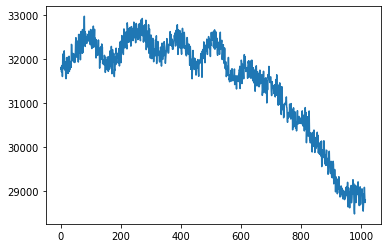

In [18]:
plt.plot(X_train[20])
plt.show()

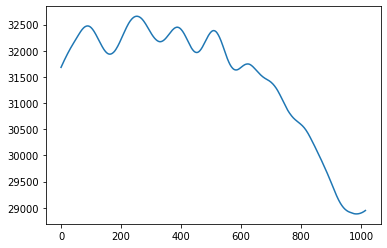

In [41]:
from scipy.signal import savgol_filter
w = savgol_filter(X_train[20], 101, 2)
plt.plot(w)  # high frequency noise removed
plt.show()

Savitzky-Golay filter (Фильтр Савицки-Голея) - фильтр для сглаживания данных. Параметр window_length - нечетное число, чем больше чем сглаженне данные

Аналоги которые можно попробовать: Kalman filter, IIR filter, LOWESS 

*   Kalman filter
*   IIR filter
*   LOWESS (Locally Weighted Scatterplot Smoothing)
*   rolling mean
*   RBF (radial basis function) interpolation

In [53]:
from scipy.signal import savgol_filter
for i in range(len(X_train)):
    X_train[i] = savgol_filter(X_train[i], 101, 2)

In [54]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [55]:
# Model 2
model2 = Sequential()
model2.add(Conv1D(128, 4, activation='relu', input_shape=(1015,1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 32 neurons
model2.add(Conv1D(128, 4, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 32 neurons
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D())
model2.add(Dropout(0.25))
model2.add(Conv1D(256, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 64 neurons
model2.add(Conv1D(256, 2, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 64 neurons
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D())
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(256, activation = 'relu', use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dense(128, activation = 'relu', use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dense(64, activation = 'relu', use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))
model2.add(Dense(2, activation = 'softmax'))
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])
model2_hist = model2.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 1012, 128)         640       
                                                                 
 conv1d_45 (Conv1D)          (None, 1009, 128)         65664     
                                                                 
 batch_normalization_55 (Bat  (None, 1009, 128)        512       
 chNormalization)                                                
                                                                 
 activation_55 (Activation)  (None, 1009, 128)         0         
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 504, 128)         0         
 g1D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 504, 128)        

In [56]:
acc = model2.evaluate(X_test, y_test)
print("Loss:", acc[0], " Accuracy:", acc[1], " F1 :", acc[2])
pred = model2.predict(X_test)
print(np.round(pred,2)[0], np.round(pred,2)[1])
print(X_test[22])
#model2.save("3.h5")

7/7 [==============================] - 0s 13ms/step - loss: 0.3861 - accuracy: 0.7838 - f1: 0.7848
Loss: 0.3861449360847473  Accuracy: 0.7837837934494019  F1 : 0.7848213911056519
7/7 [==============================] - 0s 11ms/step
[0.5 0.5] [0.48 0.52]
[35272.511719 35374.390625 35201.835938 ... 33828.355469 33551.273438
 33914.472656]


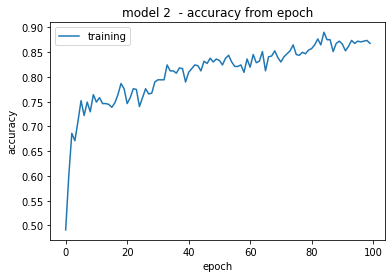

In [57]:
loss, accuracy, f1  = model2.evaluate(X_test, y_test, verbose=False)

plt.plot(model2_hist.history['accuracy'])
plt.title('model 2  - accuracy from epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [59]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
model_catboost = CatBoostClassifier(verbose=False)
model_catboost.fit(X_train, y_train_labels)
print(f'CatBoost F1 Score {f1_score(y_test_labels, model_catboost.predict(X_test))}')
print(f'CatBoost Accuracy {accuracy_score(y_test_labels, model_catboost.predict(X_test))}')

CatBoost F1 Score 0.9184549356223176
CatBoost Accuracy 0.9144144144144144


In [ ]:
!pip install tsmoothie

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f'Total amount of train measurements: {X_train.shape}')
print(f'Total amount of train labels: {y_train.shape}')
print(f'Total amount of test measurements: {X_test.shape}')
print(f'Total amount of test labels: {y_test.shape}')
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

Total amount of train measurements: (666, 1015)
Total amount of train labels: (666, 2)
Total amount of test measurements: (222, 1015)
Total amount of test labels: (222, 2)


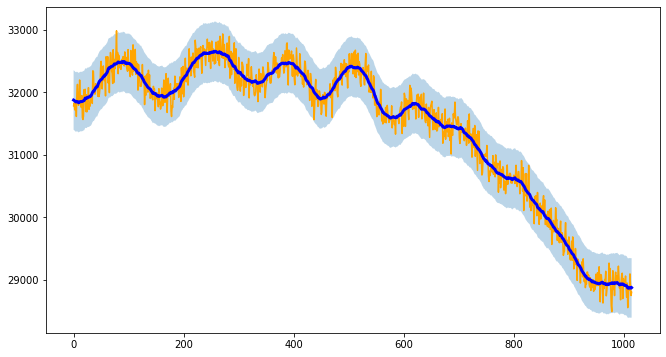

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import *

# operate smoothing
smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(X_train)

# generate intervals
low, up = smoother.get_intervals('sigma_interval', n_sigma=3)

plt.figure(figsize=(11,6))
plt.plot(smoother.data[20], color='orange')
plt.plot(smoother.smooth_data[20], linewidth=3, color='blue')
plt.fill_between(range(len(smoother.data[20])), low[20], up[20], alpha=0.3)

In [69]:
# operate smoothing
smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(X_train)
X_train = smoother.smooth_data

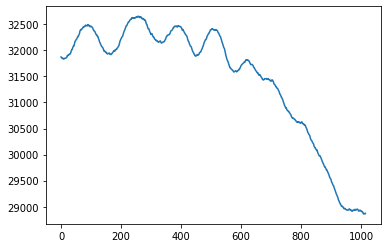

In [70]:
plt.plot(X_train[20])

In [59]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [60]:
# Model 3
model3 = Sequential()
model3.add(Conv1D(128, 4, activation='relu', input_shape=(1015,1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 32 neurons
model3.add(Conv1D(128, 4, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 32 neurons
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling1D())
model3.add(Dropout(0.25))
model3.add(Conv1D(256, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 64 neurons
model3.add(Conv1D(256, 2, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 64 neurons
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling1D())
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(256, activation = 'relu', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dense(128, activation = 'relu', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dense(64, activation = 'relu', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))
model3.add(Dense(2, activation = 'softmax'))
model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])
model3_hist = model3.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 1012, 128)         640       
                                                                 
 conv1d_21 (Conv1D)          (None, 1009, 128)         65664     
                                                                 
 batch_normalization_25 (Bat  (None, 1009, 128)        512       
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, 1009, 128)         0         
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 504, 128)         0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 504, 128)         

In [61]:
acc = model3.evaluate(X_test, y_test)
print("Loss:", acc[0], " Accuracy:", acc[1], " F1 :", acc[2])
pred = model3.predict(X_test)
print(np.round(pred,2)[0], np.round(pred,2)[1])
print(X_test[22])
#model3.save("3.h5")

7/7 [==============================] - 0s 14ms/step - loss: 0.5013 - accuracy: 0.8468 - f1: 0.8482
Loss: 0.5012955069541931  Accuracy: 0.8468468189239502  F1 : 0.8482142090797424
7/7 [==============================] - 0s 10ms/step
[0.27 0.73] [0.55 0.45]
[35264.61340742 35271.53238423 35263.08505558 ... 33901.75113423
 33901.69128039 33897.450605  ]


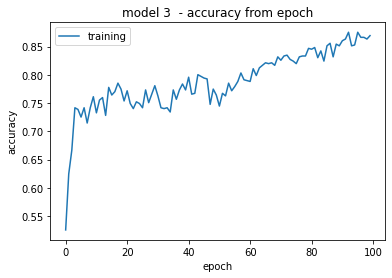

In [62]:
loss, accuracy, f1  = model3.evaluate(X_test, y_test, verbose=False)

plt.plot(model3_hist.history['accuracy'])
plt.title('model 3  - accuracy from epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [71]:
from catboost import CatBoostClassifier
model_catboost3 = CatBoostClassifier(verbose=False)
model_catboost3.fit(X_train, y_train_labels)
print(f'CatBoost F1 Score {f1_score(y_test_labels, model_catboost3.predict(X_test))}')
print(f'CatBoost Accuracy {accuracy_score(y_test_labels, model_catboost3.predict(X_test))}')

CatBoost F1 Score 0.9184549356223176
CatBoost Accuracy 0.9144144144144144


---
Вывод #2:

---
Neural Network Train: loss: 0.2720 - accuracy: 0.8754 - f1: 0.8715

CatBoost: Accuracy 0.925 F1 Score 0.93

---
After noise removed Savitzky-Golay filter:

---
Neural Network Train: loss: 0.2534 - accuracy: 0.8724 - f1: 0.8689

CatBoost: Accuracy 0.92 F1 Score 0.91

---
After noise removed ConvolutionSmoother:

---
Neural Network Train: loss: loss: 0.2582 - accuracy: 0.8754 - f1: 0.8868

CatBoost: Accuracy 0.92 F1 Score 0.91

---
Сглаживание не дало большого результата